# Train Regressao Logistica

Para a detecção dos caracteres das placas encontradas é primeiramente treinado um modelo de regressão logística com todas as fontes possíveis para escrita dos caracteres das placas. 

A imagem abaixo exemplifica uma fonte usada no treinamento.

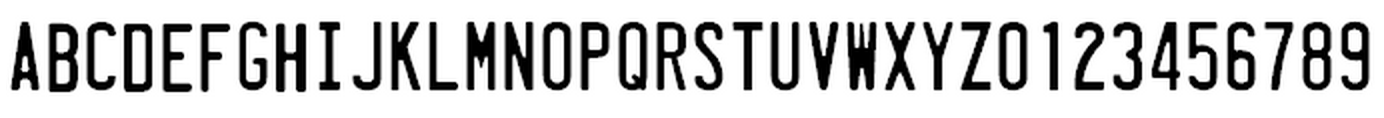

Esse programa ainda usa um outro programa auxiliar chamado descriptors encontrado na pasta tools.
Esse programa é responsável por normalizar os valores dos pixels para o treinamento da regressão logistica.

In [1]:
import cv2
import pickle
from imutils import paths
from sklearn.linear_model import LogisticRegression
from tools.descriptors import NormalizePixels
import os
import logging



In [2]:


class Train():

    def __init__(self):
        self.logging = ""
        self.alphabet = "abcdefghijklmnopqrstuvwxyz0123456789"
        self.alphabetData = []
        self.alphabetLabels = []
        self.digitsData = []
        self.digitsLabels = []
        self.size_blocks = ((5, 5), (5, 10), (10, 5), (10, 10))
        self.input_samples()
        self.training()


    def input_samples(self):
        self.desc = NormalizePixels(size_blocks=self.size_blocks)

        # Loop sobre as fontes
        for idx, fontPath in enumerate(paths.list_images(os.path.join(os.getcwd(), 'fonts'))):
            
            # Carrega a imagem da fonte, converte em escala de cinza e aplica threshold
            font = cv2.imread(fontPath)
            font = cv2.cvtColor(font, cv2.COLOR_BGR2GRAY)
            thresh = cv2.threshold(font, 128, 255, cv2.THRESH_BINARY_INV)[1]

            # Detecta contornos na imagem e classifica da esquerda para a direita
            cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)          
            cnts = sorted(cnts[0], key=lambda c:(cv2.boundingRect(c)[0] + cv2.boundingRect(c)[1]))

            # Loop sobre os contornos
            for (idx, countors) in enumerate(cnts):
                # Obtém a caixa delimitadora para o contorno, extrai o ROI e extrai recursos
                (x, y, w, h) = cv2.boundingRect(countors)
                roi = thresh[y:y + h, x:x + w]
                features = self.desc.describe(roi)

                # Verifica se este é um caracter do alfabeto
                if idx < 26:
                    self.alphabetData.append(features)
                    self.alphabetLabels.append(self.alphabet[idx])

                # Caso contrário, é um dígito
                else:
                    self.digitsData.append(features)
                    self.digitsLabels.append(self.alphabet[idx])

    def training(self):
        # Treina o classificador de caracteres
        print("Treinando o classificador de caracteres...")
        charModel = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial', max_iter=10000, verbose=1, tol=0.00005)
        charModel.fit(self.alphabetData, self.alphabetLabels)

        # Treina o classificador de dígitos
        print("Treinando o classificador de dígitos...")
        digitModel = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial', max_iter=10000, verbose=1, tol=0.00005)
        digitModel.fit(self.digitsData, self.digitsLabels)

        # Salvando o classificador de caracteres
        print("Salvando o classificador de caracteres...")
        f = open(os.path.join(os.getcwd(), "models", "simple_char.cpickle"), "wb")
        f.write(pickle.dumps(charModel))
        f.close()

        # Salvando o classificador de dígitos
        print("Salvando o classificador de dígitos...")
        f = open(os.path.join(os.getcwd(), "models", "simple_digit.cpickle"), "wb")
        f.write(pickle.dumps(digitModel))
        f.close()

        print("Treinamento concluído!")
        print("\n")


In [4]:
if __name__ == "__main__":
    Train()

Treinando o classificador de caracteres...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 403 epochs took 1 seconds
Treinando o classificador de dígitos...
convergence after 374 epochs took 0 seconds
Salvando o classificador de caracteres...
Salvando o classificador de dígitos...
Treinamento concluído!




[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
